# Unsupervised Learning: Convolutional Denoising AutoEncoder
Remove noise from hand-written digits (MNIST) images

In [ ]:
from tensorflow.keras import layers, optimizers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import callbacks
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [ ]:
epochs = 30
batch_size = 256
noise_factor = 0.5

## Prepare Data

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize image pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add gaussian noise to images
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0,
                                                        scale=1.0,
                                                        size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

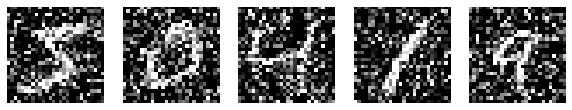

In [ ]:
# Visualize Noisy Data Samples

fig, axes = plt.subplots(1, 5, figsize=(10,2))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x_train_noisy[i]), cmap='gray')
    ax.set_axis_off()
plt.show()

## Create Layers + Model

In [ ]:
input_img = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer=optimizers.Adam(),
                    loss=losses.binary_crossentropy,
                    metrics=['accuracy'])

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248

## Training

In [ ]:
# Callbacks

model_checkpoint = callbacks.ModelCheckpoint('model_checkpoint.h5',
                                             save_best_only=True)
logger = callbacks.CSVLogger('training.log')
my_callbacks = [model_checkpoint, logger]

# Train the Model

history = autoencoder.fit(x_train_noisy, x_train, epochs=epochs,
                          batch_size=batch_size, shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          callbacks=my_callbacks)

autoencoder.save('model_final.h5')

Epoch 1/30
235/235 [==============================] - 8s 30ms/step - loss: 0.1980 - accuracy: 0.8049 - val_loss: 0.1263 - val_accuracy: 0.8071
Epoch 2/30
235/235 [==============================] - 5s 23ms/step - loss: 0.1208 - accuracy: 0.8099 - val_loss: 0.1150 - val_accuracy: 0.8092
Epoch 3/30
235/235 [==============================] - 5s 23ms/step - loss: 0.1138 - accuracy: 0.8110 - val_loss: 0.1112 - val_accuracy: 0.8114
Epoch 4/30
235/235 [==============================] - 6s 25ms/step - loss: 0.1097 - accuracy: 0.8117 - val_loss: 0.1071 - val_accuracy: 0.8113
Epoch 5/30
235/235 [==============================] - 6s 26ms/step - loss: 0.1073 - accuracy: 0.8120 - val_loss: 0.1050 - val_accuracy: 0.8114
Epoch 6/30
235/235 [==============================] - 6s 24ms/step - loss: 0.1056 - accuracy: 0.8123 - val_loss: 0.1038 - val_accuracy: 0.8111
Epoch 7/30
235/235 [==============================] - 7s 30ms/step - loss: 0.1044 - accuracy: 0.8124 - val_loss: 0.1032 - val_accuracy: 0.8120

## Train / Validation Loss Plot

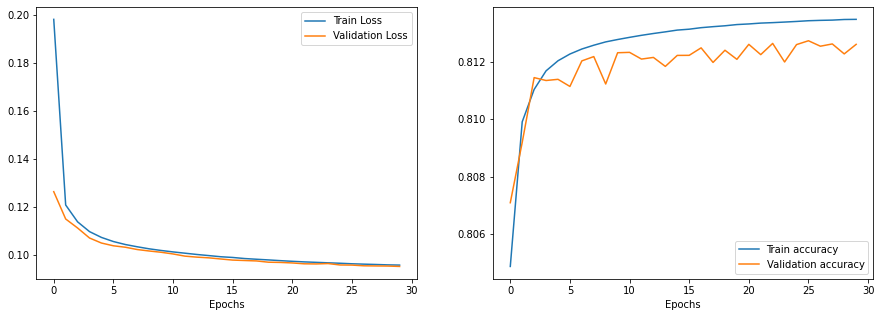

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Train accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()

plt.show()

## Evaluation

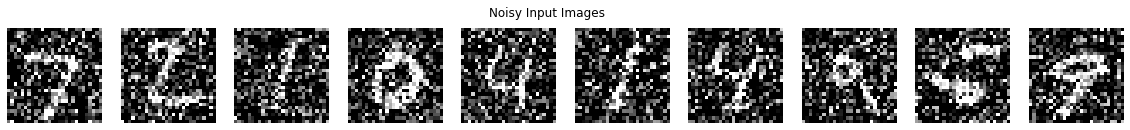

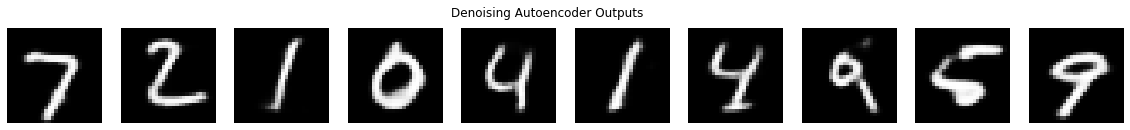

In [ ]:
# Decoder output
decoded_imgs = autoencoder.predict(x_test_noisy)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.set_axis_off()
plt.suptitle('Noisy Input Images')

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.set_axis_off()
plt.suptitle('Denoising Autoencoder Outputs')

plt.show()

## Visualize Encoder Output (Latent Space Representation)

In [ ]:
# Encoder output
encoder_model = Model(input_img, encoded)
encoder_model.summary()
encoded_data = encoder_model.predict(x_test_noisy)

Text(0.5, 0.98, 'Encoder outputs')

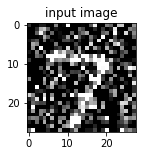

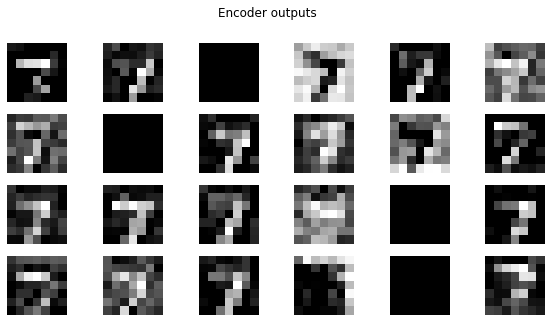

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(x_test_noisy[0].reshape(28, 28), cmap='gray')
plt.title('input image')

fig, axes = plt.subplots(4, 6, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(encoded_data[0][:,:,i], cmap='gray')
    ax.set_axis_off()
plt.suptitle('Encoder outputs')